# Generalized Mutual Information

We compute the generalized mutual information on the noisy-label MNIST problem

# Reference problem

We define a very easy classification problem
in order to calibrate the scale of MMD and Wasserstein divergences,
since those divergences are not expressed in nats.

In [133]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
parser.add_argument('--dataset', required=True, choices=['mnist', 'svhn'], default=False,
                    help='For Saving the current Model')

args = parser.parse_args(['--dataset', 'svhn'])
use_cuda = not args.no_cuda and torch.cuda.is_available()



def corruption_to_mi_wrong(alpha):
    return np.log(k) + np.log(1-(1-1./k)*alpha)


def corruption_to_mi(alpha, k=10.):
    p_y_true = (1-alpha) + alpha / k
    p_y_false = alpha / k + 1e-8 # prevemnt 0 alpha error
    entropy = np.log(k)
    conditional_entropy = -(p_y_true * np.log(p_y_true) + (k-1) * p_y_false * np.log(p_y_false))
    return entropy - conditional_entropy
    
#alpha = np.linspace(0, 1, 100)
#k = 10
#mi = corruption_to_mi(alpha)
#plt.plot(alpha, mi)
#plt.xlabel('Ratio of corrupted labels')
#plt.ylabel('Mutual information (nats)')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = self.fc1(x.view(len(x), -1))
        return F.log_softmax(x, dim=1)
    
    
class FlattenLayer(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        
    def forward(self, x):
        return x.view(len(x), -1)
    
    
# Architecture loosely inspired by
# https://www.kaggle.com/olgabelitskaya/svhn-digit-recognition
class SvhnCNN(nn.Module):
    def __init__(self):
        super(SvhnCNN, self).__init__()
        self.main = nn.Sequential(
            # 32x32 - 3 channels
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 20, 4, 2, 1),
            nn.ReLU(True),
            # 16x16 - 20 channels
            nn.BatchNorm2d(20),
            nn.Conv2d(20, 32, 3, 1, 0),
            nn.ReLU(True),            
            # 14x14 - 32 channels
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),           
            # 7x7 - 32 channels
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 1, 0),
            nn.ReLU(True),  
            # 5x5 - 64
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 0),
            nn.ReLU(True),  
            # 3x3 - 64
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 196, 3, 1, 0),
            nn.ReLU(True),  
            # 1x1 - 196,
            nn.BatchNorm2d(196),
            nn.Conv2d(196, 512, 1, 1, 0),
            nn.ReLU(True),  
            # 1x1 - 512 channels
            FlattenLayer(),            
            nn.Linear(512, 10),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
    
class SvhnLinear(nn.Module):
    def __init__(self):
        super(SvhnLinear, self).__init__()
        self.main = nn.Sequential(
            FlattenLayer(),
            nn.Linear(3*32*32, 10),
            nn.LogSoftmax(1)
        )
        
    def forward(self, x):
        x = self.main(x)
        return x
    
    
def do_epoch(args, mode, model, device, loader, optimizer=None, info=''):
    if mode=='train':
        model.train()
    else:
        model.eval()
        
    losses = []
    accuracies = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = F.nll_loss(output, target)

        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        if mode == 'train':
            #print 'training'
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if batch_idx % args.log_interval == 0:
            print('{} Batch {}/{} Accuracy {:.3f}\tLoss: {:.3f}'.format(
                info, batch_idx, len(loader), np.mean(accuracies), np.mean(losses)))
    return losses, accuracies



# Reference problem
class ReferenceDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):
        
        self.dataset = dataset
        
        if dataset == 'mnist':
            X = torch.zeros(10, 784)
            Y = torch.arange(10)
            for i in xrange(10):
                X[i, 78*i:78*(i+1)] = 1
            X = X.view(len(X), 1, 28, 28)        

            # Repeat X and Y 6000 times
            X = np.repeat(X, 6000, 0)
            Y = np.repeat(Y, 6000, 0)
        elif dataset == 'svhn':
            X = torch.zeros(10, 3*32*32)
            Y = torch.arange(10)
            for i in xrange(10):
                X[i, 307*i:307*(i+1)] = 1
            X = X.view(len(X), 3, 32, 32)        

            # Repeat X and Y 6000 times
            X = np.repeat(X, 6000, 0)
            Y = np.repeat(Y, 6000, 0)            
        
        self.X = X
        self.Y = Y
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx].item()
    
    
class CorruptedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, corruption, classes=None):
        self.dataset = dataset
        self.corruption = corruption
        self.corrupted = (np.random.uniform(size=len(dataset)) < corruption)
        print ('Corrupting dataset')
        if classes is not None:
            self.labels = np.random.randint(0, classes, len(dataset))
        else:
            self.labels = np.asarray([y for x,y in self.dataset])
        np.random.shuffle(self.labels)
        self.labels = torch.LongTensor(self.labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.corrupted[idx]:
            y = self.labels[idx].item()
        return x, y
    
    

#torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

if args.dataset == 'mnist':
    train_dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    test_dataset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.1307,), (0.3081,))
                       ]))
elif args.dataset == 'svhn':
    train_dataset = datasets.SVHN('../data', split='train', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
    test_dataset = datasets.SVHN('../data', split='test', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
    
corruptions = np.linspace(0, 1, 5)


def make_infinite(iterator):
    while True:
        for x in iterator:
            yield x
            

def compute_divergence(Net, corruptions, epochs=10, reference=False):

    # Train Parametric
    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption = {}'.format(corruption))

        model = Net().to(device)
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)
            test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)
            test_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)
           
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=args.batch_size, shuffle=True, **kwargs)
        test_corrupted_loader = torch.utils.data.DataLoader(test_corrupted, batch_size=args.test_batch_size, shuffle=True, **kwargs)

        for epoch in range(1, epochs+1):
            train_losses, train_accuracies = do_epoch(args, 'train', model, device, train_corrupted_loader, 
                                                      optimizer, info='Train Epoch {}'.format(epoch))

            print ('Corruption: {}, MI: {:.2} bits / {:.2} nats'.format(corruption, corruption_to_mi(corruption), corruption_to_mi(corruption)/np.log(2)))

            test_losses, test_accuracies = do_epoch(args, 'test', model, device, test_corrupted_loader, info='Test {}'.format(epoch))
            print ('CORRUPTED {}'.format(np.mean(test_losses)))


        all_train_losses.append(np.mean(train_losses))
        all_test_losses.append(np.mean(test_losses))

    return all_train_losses, all_test_losses

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


# Neural Divergence

In [138]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(Net, corruptions)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnCNN, corruptions)
    
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_cnn.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/1145 Accuracy 0.078	Loss: 2.307
Train Epoch 1 Batch 100/1145 Accuracy 0.215	Loss: 2.174
Train Epoch 1 Batch 200/1145 Accuracy 0.280	Loss: 2.033
Train Epoch 1 Batch 300/1145 Accuracy 0.358	Loss: 1.863
Train Epoch 1 Batch 400/1145 Accuracy 0.429	Loss: 1.689
Train Epoch 1 Batch 500/1145 Accuracy 0.489	Loss: 1.531
Train Epoch 1 Batch 600/1145 Accuracy 0.539	Loss: 1.395
Train Epoch 1 Batch 700/1145 Accuracy 0.579	Loss: 1.285
Train Epoch 1 Batch 800/1145 Accuracy 0.610	Loss: 1.198
Train Epoch 1 Batch 900/1145 Accuracy 0.636	Loss: 1.122
Train Epoch 1 Batch 1000/1145 Accuracy 0.657	Loss: 1.059
Train Epoch 1 Batch 1100/1145 Accuracy 0.676	Loss: 1.006
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/27 Accuracy 0.858	Loss: 0.466
CORRUPTED 0.446040496782
Train Epoch 2 Batch 0/1145 Accuracy 0.891	Loss: 0.403
Train Epoch 2 Batch 100/1145 Accuracy 0.869	Loss: 0.425
Train Epoch 2 Batch 200/1145 Accuracy 0.870	Loss: 0.

Train Epoch 1 Batch 500/1145 Accuracy 0.352	Loss: 1.947
Train Epoch 1 Batch 600/1145 Accuracy 0.388	Loss: 1.880
Train Epoch 1 Batch 700/1145 Accuracy 0.421	Loss: 1.819
Train Epoch 1 Batch 800/1145 Accuracy 0.447	Loss: 1.768
Train Epoch 1 Batch 900/1145 Accuracy 0.468	Loss: 1.729
Train Epoch 1 Batch 1000/1145 Accuracy 0.485	Loss: 1.693
Train Epoch 1 Batch 1100/1145 Accuracy 0.499	Loss: 1.665
Corruption: 0.25, MI: 1.3 bits / 1.8 nats
Test 1 Batch 0/27 Accuracy 0.657	Loss: 1.361
CORRUPTED 1.37381315673
Train Epoch 2 Batch 0/1145 Accuracy 0.719	Loss: 1.128
Train Epoch 2 Batch 100/1145 Accuracy 0.659	Loss: 1.329
Train Epoch 2 Batch 200/1145 Accuracy 0.661	Loss: 1.322
Train Epoch 2 Batch 300/1145 Accuracy 0.662	Loss: 1.318
Train Epoch 2 Batch 400/1145 Accuracy 0.662	Loss: 1.321
Train Epoch 2 Batch 500/1145 Accuracy 0.665	Loss: 1.315
Train Epoch 2 Batch 600/1145 Accuracy 0.663	Loss: 1.320
Train Epoch 2 Batch 700/1145 Accuracy 0.664	Loss: 1.319
Train Epoch 2 Batch 800/1145 Accuracy 0.665	Loss:

Train Epoch 1 Batch 1100/1145 Accuracy 0.307	Loss: 2.087
Corruption: 0.5, MI: 0.63 bits / 0.9 nats
Test 1 Batch 0/27 Accuracy 0.398	Loss: 1.997
CORRUPTED 1.92190074921
Train Epoch 2 Batch 0/1145 Accuracy 0.641	Loss: 1.584
Train Epoch 2 Batch 100/1145 Accuracy 0.442	Loss: 1.882
Train Epoch 2 Batch 200/1145 Accuracy 0.443	Loss: 1.885
Train Epoch 2 Batch 300/1145 Accuracy 0.447	Loss: 1.882
Train Epoch 2 Batch 400/1145 Accuracy 0.448	Loss: 1.882
Train Epoch 2 Batch 500/1145 Accuracy 0.450	Loss: 1.877
Train Epoch 2 Batch 600/1145 Accuracy 0.450	Loss: 1.876
Train Epoch 2 Batch 700/1145 Accuracy 0.451	Loss: 1.873
Train Epoch 2 Batch 800/1145 Accuracy 0.452	Loss: 1.871
Train Epoch 2 Batch 900/1145 Accuracy 0.453	Loss: 1.870
Train Epoch 2 Batch 1000/1145 Accuracy 0.454	Loss: 1.869
Train Epoch 2 Batch 1100/1145 Accuracy 0.455	Loss: 1.867
Corruption: 0.5, MI: 0.63 bits / 0.9 nats
Test 2 Batch 0/27 Accuracy 0.476	Loss: 1.832
CORRUPTED 1.85756182229
Train Epoch 3 Batch 0/1145 Accuracy 0.453	Loss: 1

Train Epoch 2 Batch 300/1145 Accuracy 0.204	Loss: 2.241
Train Epoch 2 Batch 400/1145 Accuracy 0.207	Loss: 2.239
Train Epoch 2 Batch 500/1145 Accuracy 0.209	Loss: 2.238
Train Epoch 2 Batch 600/1145 Accuracy 0.213	Loss: 2.235
Train Epoch 2 Batch 700/1145 Accuracy 0.216	Loss: 2.233
Train Epoch 2 Batch 800/1145 Accuracy 0.219	Loss: 2.231
Train Epoch 2 Batch 900/1145 Accuracy 0.221	Loss: 2.229
Train Epoch 2 Batch 1000/1145 Accuracy 0.223	Loss: 2.228
Train Epoch 2 Batch 1100/1145 Accuracy 0.225	Loss: 2.226
Corruption: 0.75, MI: 0.19 bits / 0.27 nats
Test 2 Batch 0/27 Accuracy 0.225	Loss: 2.240
CORRUPTED 2.21350084411
Train Epoch 3 Batch 0/1145 Accuracy 0.281	Loss: 2.151
Train Epoch 3 Batch 100/1145 Accuracy 0.247	Loss: 2.203
Train Epoch 3 Batch 200/1145 Accuracy 0.253	Loss: 2.193
Train Epoch 3 Batch 300/1145 Accuracy 0.253	Loss: 2.196
Train Epoch 3 Batch 400/1145 Accuracy 0.256	Loss: 2.192
Train Epoch 3 Batch 500/1145 Accuracy 0.258	Loss: 2.191
Train Epoch 3 Batch 600/1145 Accuracy 0.258	Los

Train Epoch 2 Batch 800/1145 Accuracy 0.105	Loss: 2.303
Train Epoch 2 Batch 900/1145 Accuracy 0.105	Loss: 2.303
Train Epoch 2 Batch 1000/1145 Accuracy 0.105	Loss: 2.303
Train Epoch 2 Batch 1100/1145 Accuracy 0.105	Loss: 2.303
Corruption: 1.0, MI: -1.2e-07 bits / -1.7e-07 nats
Test 2 Batch 0/27 Accuracy 0.086	Loss: 2.310
CORRUPTED 2.30500360771
Train Epoch 3 Batch 0/1145 Accuracy 0.141	Loss: 2.304
Train Epoch 3 Batch 100/1145 Accuracy 0.117	Loss: 2.298
Train Epoch 3 Batch 200/1145 Accuracy 0.120	Loss: 2.298
Train Epoch 3 Batch 300/1145 Accuracy 0.118	Loss: 2.298
Train Epoch 3 Batch 400/1145 Accuracy 0.119	Loss: 2.298
Train Epoch 3 Batch 500/1145 Accuracy 0.116	Loss: 2.299
Train Epoch 3 Batch 600/1145 Accuracy 0.115	Loss: 2.299
Train Epoch 3 Batch 700/1145 Accuracy 0.115	Loss: 2.299
Train Epoch 3 Batch 800/1145 Accuracy 0.114	Loss: 2.299
Train Epoch 3 Batch 900/1145 Accuracy 0.114	Loss: 2.300
Train Epoch 3 Batch 1000/1145 Accuracy 0.114	Loss: 2.300
Train Epoch 3 Batch 1100/1145 Accuracy 

In [131]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions, epochs=1)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnLinear, corruptions, epochs=1)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_logistic.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/1145 Accuracy 0.188	Loss: 2.242
Train Epoch 1 Batch 100/1145 Accuracy 0.161	Loss: 2.290
Train Epoch 1 Batch 200/1145 Accuracy 0.162	Loss: 2.292
Train Epoch 1 Batch 300/1145 Accuracy 0.170	Loss: 2.288
Train Epoch 1 Batch 400/1145 Accuracy 0.173	Loss: 2.284
Train Epoch 1 Batch 500/1145 Accuracy 0.175	Loss: 2.282
Train Epoch 1 Batch 600/1145 Accuracy 0.177	Loss: 2.280
Train Epoch 1 Batch 700/1145 Accuracy 0.179	Loss: 2.279
Train Epoch 1 Batch 800/1145 Accuracy 0.180	Loss: 2.277
Train Epoch 1 Batch 900/1145 Accuracy 0.181	Loss: 2.276
Train Epoch 1 Batch 1000/1145 Accuracy 0.182	Loss: 2.273
Train Epoch 1 Batch 1100/1145 Accuracy 0.184	Loss: 2.271
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/27 Accuracy 0.156	Loss: 2.308
CORRUPTED 2.30605163398
Corruption = 0.25
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/1145 Accuracy 0.047	Loss: 2.356
Train Epoch 1 Batch 100/1145 Accuracy 0.136	Loss: 2.3

In [139]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(Net, corruptions, reference=True)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnCNN, corruptions, reference=True)
    
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_cnn.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.125	Loss: 2.288
Train Epoch 1 Batch 100/938 Accuracy 0.982	Loss: 0.591
Train Epoch 1 Batch 200/938 Accuracy 0.991	Loss: 0.330
Train Epoch 1 Batch 300/938 Accuracy 0.994	Loss: 0.230
Train Epoch 1 Batch 400/938 Accuracy 0.996	Loss: 0.178
Train Epoch 1 Batch 500/938 Accuracy 0.996	Loss: 0.145
Train Epoch 1 Batch 600/938 Accuracy 0.997	Loss: 0.122
Train Epoch 1 Batch 700/938 Accuracy 0.997	Loss: 0.106
Train Epoch 1 Batch 800/938 Accuracy 0.998	Loss: 0.094
Train Epoch 1 Batch 900/938 Accuracy 0.998	Loss: 0.084
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/60 Accuracy 1.000	Loss: 0.004
CORRUPTED 0.00404667853533
Train Epoch 2 Batch 0/938 Accuracy 1.000	Loss: 0.006
Train Epoch 2 Batch 100/938 Accuracy 1.000	Loss: 0.005
Train Epoch 2 Batch 200/938 Accuracy 1.000	Loss: 0.005
Train Epoch 2 Batch 300/938 Accuracy 1.000	Loss: 0.004
Train Epoch 2 Batch 400/938 Accuracy 1.000	Loss: 0.004
Train Epoch

Train Epoch 3 Batch 300/938 Accuracy 0.780	Loss: 1.020
Train Epoch 3 Batch 400/938 Accuracy 0.781	Loss: 1.017
Train Epoch 3 Batch 500/938 Accuracy 0.780	Loss: 1.019
Train Epoch 3 Batch 600/938 Accuracy 0.779	Loss: 1.024
Train Epoch 3 Batch 700/938 Accuracy 0.777	Loss: 1.030
Train Epoch 3 Batch 800/938 Accuracy 0.777	Loss: 1.031
Train Epoch 3 Batch 900/938 Accuracy 0.777	Loss: 1.031
Corruption: 0.25, MI: 1.3 bits / 1.8 nats
Test 3 Batch 0/60 Accuracy 0.781	Loss: 1.011
CORRUPTED 1.03177630504
Train Epoch 4 Batch 0/938 Accuracy 0.781	Loss: 1.014
Train Epoch 4 Batch 100/938 Accuracy 0.775	Loss: 1.037
Train Epoch 4 Batch 200/938 Accuracy 0.777	Loss: 1.029
Train Epoch 4 Batch 300/938 Accuracy 0.777	Loss: 1.029
Train Epoch 4 Batch 400/938 Accuracy 0.775	Loss: 1.034
Train Epoch 4 Batch 500/938 Accuracy 0.776	Loss: 1.033
Train Epoch 4 Batch 600/938 Accuracy 0.776	Loss: 1.033
Train Epoch 4 Batch 700/938 Accuracy 0.777	Loss: 1.030
Train Epoch 4 Batch 800/938 Accuracy 0.777	Loss: 1.029
Train Epoch

Train Epoch 5 Batch 700/938 Accuracy 0.553	Loss: 1.677
Train Epoch 5 Batch 800/938 Accuracy 0.551	Loss: 1.681
Train Epoch 5 Batch 900/938 Accuracy 0.552	Loss: 1.678
Corruption: 0.5, MI: 0.63 bits / 0.9 nats
Test 5 Batch 0/60 Accuracy 0.551	Loss: 1.677
CORRUPTED 1.67957960169
Train Epoch 6 Batch 0/938 Accuracy 0.562	Loss: 1.659
Train Epoch 6 Batch 100/938 Accuracy 0.544	Loss: 1.699
Train Epoch 6 Batch 200/938 Accuracy 0.548	Loss: 1.688
Train Epoch 6 Batch 300/938 Accuracy 0.549	Loss: 1.685
Train Epoch 6 Batch 400/938 Accuracy 0.550	Loss: 1.684
Train Epoch 6 Batch 500/938 Accuracy 0.552	Loss: 1.679
Train Epoch 6 Batch 600/938 Accuracy 0.554	Loss: 1.673
Train Epoch 6 Batch 700/938 Accuracy 0.553	Loss: 1.677
Train Epoch 6 Batch 800/938 Accuracy 0.552	Loss: 1.679
Train Epoch 6 Batch 900/938 Accuracy 0.552	Loss: 1.679
Corruption: 0.5, MI: 0.63 bits / 0.9 nats
Test 6 Batch 0/60 Accuracy 0.546	Loss: 1.686
CORRUPTED 1.6800355494
Train Epoch 7 Batch 0/938 Accuracy 0.516	Loss: 1.759
Train Epoch 7

Test 7 Batch 0/60 Accuracy 0.332	Loss: 2.102
CORRUPTED 2.11397425731
Train Epoch 8 Batch 0/938 Accuracy 0.312	Loss: 2.128
Train Epoch 8 Batch 100/938 Accuracy 0.333	Loss: 2.105
Train Epoch 8 Batch 200/938 Accuracy 0.328	Loss: 2.114
Train Epoch 8 Batch 300/938 Accuracy 0.325	Loss: 2.118
Train Epoch 8 Batch 400/938 Accuracy 0.327	Loss: 2.116
Train Epoch 8 Batch 500/938 Accuracy 0.326	Loss: 2.116
Train Epoch 8 Batch 600/938 Accuracy 0.327	Loss: 2.116
Train Epoch 8 Batch 700/938 Accuracy 0.326	Loss: 2.117
Train Epoch 8 Batch 800/938 Accuracy 0.325	Loss: 2.119
Train Epoch 8 Batch 900/938 Accuracy 0.326	Loss: 2.117
Corruption: 0.75, MI: 0.19 bits / 0.27 nats
Test 8 Batch 0/60 Accuracy 0.341	Loss: 2.096
CORRUPTED 2.11509862343
Train Epoch 9 Batch 0/938 Accuracy 0.281	Loss: 2.187
Train Epoch 9 Batch 100/938 Accuracy 0.323	Loss: 2.121
Train Epoch 9 Batch 200/938 Accuracy 0.329	Loss: 2.113
Train Epoch 9 Batch 300/938 Accuracy 0.328	Loss: 2.114
Train Epoch 9 Batch 400/938 Accuracy 0.326	Loss: 2.1

Train Epoch 10 Batch 200/938 Accuracy 0.098	Loss: 2.305
Train Epoch 10 Batch 300/938 Accuracy 0.100	Loss: 2.304
Train Epoch 10 Batch 400/938 Accuracy 0.101	Loss: 2.304
Train Epoch 10 Batch 500/938 Accuracy 0.100	Loss: 2.305
Train Epoch 10 Batch 600/938 Accuracy 0.100	Loss: 2.304
Train Epoch 10 Batch 700/938 Accuracy 0.101	Loss: 2.304
Train Epoch 10 Batch 800/938 Accuracy 0.101	Loss: 2.305
Train Epoch 10 Batch 900/938 Accuracy 0.101	Loss: 2.305
Corruption: 1.0, MI: -1.2e-07 bits / -1.7e-07 nats
Test 10 Batch 0/60 Accuracy 0.087	Loss: 2.305
CORRUPTED 2.30438869794


In [134]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions, epochs=1, reference=True)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnLinear, corruptions, epochs=1, reference=True)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_logistic.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.078	Loss: 2.341
Train Epoch 1 Batch 100/938 Accuracy 0.985	Loss: 0.145
Train Epoch 1 Batch 200/938 Accuracy 0.992	Loss: 0.078
Train Epoch 1 Batch 300/938 Accuracy 0.995	Loss: 0.054
Train Epoch 1 Batch 400/938 Accuracy 0.996	Loss: 0.042
Train Epoch 1 Batch 500/938 Accuracy 0.997	Loss: 0.034
Train Epoch 1 Batch 600/938 Accuracy 0.997	Loss: 0.029
Train Epoch 1 Batch 700/938 Accuracy 0.998	Loss: 0.025
Train Epoch 1 Batch 800/938 Accuracy 0.998	Loss: 0.022
Train Epoch 1 Batch 900/938 Accuracy 0.998	Loss: 0.020
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/60 Accuracy 1.000	Loss: 0.002
CORRUPTED 0.00156497953964
Corruption = 0.25
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.203	Loss: 2.313
Train Epoch 1 Batch 100/938 Accuracy 0.763	Loss: 1.094
Train Epoch 1 Batch 200/938 Accuracy 0.773	Loss: 1.051
Train Epoch 1 Batch 300/938 Accuracy 0.774	Loss: 1.044
Train Epoc

# Intra and Inter-class Variances

In [322]:
# Compute MNIST intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in train_dataset:
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(-1, 28*28)
    
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))


Variance class 0: 49.92
Variance class 1: 22.48
Variance class 2: 50.76
Variance class 3: 44.94
Variance class 4: 40.87
Variance class 5: 47.58
Variance class 6: 43.09
Variance class 7: 37.47
Variance class 8: 45.60
Variance class 9: 38.57
Inter-class variance: 52.73


Variance class 0: 0.00
Variance class 1: 0.00
Variance class 2: 0.00
Variance class 3: 0.00
Variance class 4: 0.00
Variance class 5: 0.00
Variance class 6: 0.00
Variance class 7: 0.00
Variance class 8: 0.00
Variance class 9: 0.00
Inter-class variance: 70.20


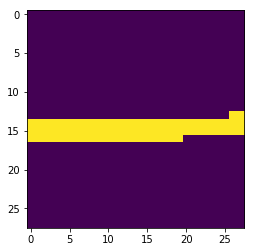

In [323]:
# Compute Reference intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in ReferenceDataset():
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(-1, 28*28)
    
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))

plt.imshow(X[5].mean(0).view(28,28))

# MMD

In [151]:
# MMD
class MMDKernel(object):
    def dot(self, x1, x2):
        raise Exception('Implement')

    def h(self, X1, Y1, X2, Y2):
        k_X1_X2 = self.dot(X1, X2)
        k_Y1_Y2 = self.dot(Y1, Y2)
        k_X1_Y2 = self.dot(X1, Y2)
        k_X2_Y1 = self.dot(X2, Y1)
        stat =  k_X1_X2 + k_Y1_Y2 - k_X1_Y2 - k_X2_Y1
        return stat
    
    def split(self, X):
        return X[0::2], X[1::2]
    
        
class GaussianKernel(MMDKernel):
    def __init__(self, sigma=1.):
        self.sigma = sigma
        
    def dot(self, x1, x2):
        x1 = x1.view(len(x1), -1)  # flatten
        x2 = x2.view(len(x2), -1)  # flatten
        
        delta = x1-x2
        dot = (delta*delta).mean(1)
        return np.exp(-dot / self.sigma**2)


class ZeroOneKernel(MMDKernel):
    def dot(self, y1, y2):
        # Return 1 or less (shouldn't be zero)
        return np.exp(-(y1 != y2).float())

    
    
class JointKernel(MMDKernel):
    def __init__(self, kx, ky):
        self.kx = kx
        self.ky = ky
        
    def dot(self, (x1, y1), (x2, y2)):
        dotx = self.kx.dot(x1, x2)
        doty = self.ky.dot(y1, y2)
        return dotx * doty
    
    def split(self, (X_image, X_label)):
        X1 = (X_image[0::2], X_label[0::2])
        X2 = (X_image[1::2], X_label[1::2])
        return X1, X2
        
# Here X~p and Y~q
def linear_mmd(kernel, X, Y):
    # linear time unbiased estimator
    # h((xi,yi), (xj, yj)) = k(xi,xj)+k(yi,yj)-k(xi,yj)-k(xj,yi)
    assert len(X)==len(Y)

    X1, X2 = kernel.split(X)
    Y1, Y2 = kernel.split(Y)

    hs = kernel.h(X1, Y1, X2, Y2) 
    mmd2 = hs.mean()
    
    return mmd2
    
    
def linear_mmd_validation(kernel, X_train, Y_train, X_val, Y_val):
    '''
    this should return a lower bound on MMD,
    it takes the witness function computed on the training empirical distributions X_train, Y_train
    and applies it on the validation empirical distributions X_val, Y_val
    '''
    assert len(X_train)==len(Y_train)
    assert len(X_val)==len(Y_val)
    assert len(X_train)==len(X_val)
    
    hs = kernel.h(X_train, Y_train, X_val, Y_val) 
    mmd2 = hs.mean()
    
    return mmd2
    
# Independence test

def compute_mmd(corruptions, joint_kernel, epochs=1, reference=False, batch_size=1000):

    all_mmds_train = []
    all_mmds_test = []
    #all_mmds_std = []
    

    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1, classes=10)  # X totally independent Y
            # for validaiton only
            #test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
            #test_random = CorruptedDataset(test_dataset, 1, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(args.dataset), 1, classes=10)  # X totally independent Y
            # for validation only
            #test_corrupted = CorruptedDataset(ReferenceDataset(), corruption)
            #test_random = CorruptedDataset(ReferenceDataset(), 1, classes=10)  # X totally independent Y
            
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, drop_last=True, shuffle=True, **kwargs)
        train_random_loader = torch.utils.data.DataLoader(train_random, batch_size=batch_size, drop_last=True, shuffle=True, **kwargs)
        # for validation MMD
        #test_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, shuffle=True, **kwargs)
        #test_random_loader = torch.utils.data.DataLoader(test_random, batch_size=batch_size, shuffle=True, **kwargs)
        #test_corrupted_iter = make_infinite(test_corrupted_loader)
        #test_random_iter = make_infinite(test_random_loader)
        
        
        linear_mmds_train = []
        linear_mmds_val = []
        for epoch in xrange(1, epochs+1):
            # Can run many times to reduce variance
            for batch_idx, (X, Y) in enumerate(zip(train_corrupted_loader, train_random_loader)):
                
                mmd_train = linear_mmd(joint_kernel, X, Y)
                
                # for validation only
                #X_val, Y_val = test_corrupted_iter.next(), test_random_iter.next()
                #mmd_val = linear_mmd_validation(joint_kernel, X, Y, X_val, Y_val)
                               
                
                linear_mmds_train.append(mmd_train.item())
                #linear_mmds_val.append(mmd_val.item())
                
                if batch_idx % 100 == 0 or batch_idx==len(train_corrupted_loader)-1:              
                    print ('Epoch {}/{} Batch {}/{} MMD train {:.5} '.format(
                        epoch, epochs, batch_idx, len(train_corrupted_loader), 
                        np.mean(linear_mmds_train)))
        all_mmds_train.append([np.mean(linear_mmds_train)])
        all_mmds_test.append([np.mean(linear_mmds_train)])  # THIS IS WRONG BUT VALIDATION MMD IS ANNOYING TO COMPUTE
        #all_mmds_test.append([np.mean(linear_mmds_val)])
        #all_mmds_std.append([np.std(linear_mmds)])

    return all_mmds_train, all_mmds_test         

MMD_Epochs = 100
kernel_x = GaussianKernel()
kernel_y = ZeroOneKernel()
joint_kernel = JointKernel(kernel_x, kernel_y)

In [ ]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=False)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, '{}_real_mmd.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset
Corrupting dataset
Epoch 1/100 Batch 0/73 MMD train -0.017776 
Epoch 1/100 Batch 72/73 MMD train 0.010693 
Epoch 2/100 Batch 0/73 MMD train 0.01093 
Epoch 2/100 Batch 72/73 MMD train 0.010543 
Epoch 3/100 Batch 0/73 MMD train 0.01064 
Epoch 3/100 Batch 72/73 MMD train 0.010113 
Epoch 4/100 Batch 0/73 MMD train 0.01014 
Epoch 4/100 Batch 72/73 MMD train 0.010119 
Epoch 5/100 Batch 0/73 MMD train 0.010104 
Epoch 5/100 Batch 72/73 MMD train 0.0097475 
Epoch 6/100 Batch 0/73 MMD train 0.009835 
Epoch 6/100 Batch 72/73 MMD train 0.0095191 
Epoch 7/100 Batch 0/73 MMD train 0.0095226 
Epoch 7/100 Batch 72/73 MMD train 0.0097629 
Epoch 8/100 Batch 0/73 MMD train 0.0097811 
Epoch 8/100 Batch 72/73 MMD train 0.0098309 
Epoch 9/100 Batch 0/73 MMD train 0.0098202 
Epoch 9/100 Batch 72/73 MMD train 0.010032 
Epoch 10/100 Batch 0/73 MMD train 0.010031 
Epoch 10/100 Batch 72/73 MMD train 0.0097862 
Epoch 11/100 Batch 0/73 MMD train 0.0097904 
Epoch 11/100 Batch 72/73

In [ ]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=True)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, '{}_reference_mmd.pt'.format(args.dataset))

# Random Forest


In [143]:
def dataset_to_numpy(dataset):    
    X = []
    Y = []
    for i, (x, y) in enumerate(dataset):
        X.append(x.numpy().flatten())
        if not isinstance(y, int):
            y = y.item()
        Y.append(y)
    
        if i % 10000 ==0 :
            print ('{}/{}'.format(i, len(dataset)))
    X = np.asarray(X)
    Y = np.asarray(Y)
    # shuffle
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    # make contiguous
    X = X[idx].copy()
    Y = Y[idx].copy()
    
    return X, Y


def get_regularized_logloss(Y_prob, Y_test, regularize=0.01):
    uniform = np.ones((len(Y_prob), 10)) / 10.
    Y_regularized = regularize*uniform+(1-regularize)*Y_prob
    logloss = -np.log(Y_regularized)[range(len(Y_test)), Y_test].mean()
    #print (Y_regularized.sum(1))
    return logloss

    
def compute_rf(corruptions, reference=False):

    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption, classes=10)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption, classes=10)
        
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_test, Y_test = dataset_to_numpy(test_corrupted)

        print ('Fitting random forest')
        clf = RandomForestClassifier()
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print ('accuracy', (Y_pred == Y_test).mean())

        # Log loss train
        Y_prob_train = clf.predict_proba(X_train)
        logloss_train = get_regularized_logloss(Y_prob_train, Y_train)

        # Log loss test
        Y_prob_test = clf.predict_proba(X_test)
        logloss_test = get_regularized_logloss(Y_prob_test, Y_test)

        all_test_losses.append(logloss_test)
        all_train_losses.append(logloss_train)

        print ('Log loss Train {}'.format(logloss_train))
        print ('Log loss Test {}'.format(logloss_test))

    return all_train_losses, all_test_losses

In [144]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=False)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_rf.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/73257
10000/73257
20000/73257
30000/73257
40000/73257
50000/73257
60000/73257
70000/73257
0/26032
10000/26032
20000/26032
Fitting random forest


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.5429855562384758
Log loss Train 0.292342284366
Log loss Test 1.77206738831
Corruption 0.25
Corrupting dataset
Corrupting dataset
0/73257
10000/73257
20000/73257
30000/73257
40000/73257
50000/73257
60000/73257
70000/73257
0/26032
10000/26032
20000/26032
Fitting random forest
accuracy 0.37012138905961894
Log loss Train 0.360148810652
Log loss Test 2.57022842476
Corruption 0.5
Corrupting dataset
Corrupting dataset
0/73257
10000/73257
20000/73257
30000/73257
40000/73257
50000/73257
60000/73257
70000/73257
0/26032
10000/26032
20000/26032
Fitting random forest
accuracy 0.22503073140749846
Log loss Train 0.406312354025
Log loss Test 3.15511435719
Corruption 0.75
Corrupting dataset
Corrupting dataset
0/73257
10000/73257
20000/73257
30000/73257
40000/73257
50000/73257
60000/73257
70000/73257
0/26032
10000/26032
20000/26032
Fitting random forest
accuracy 0.13022433927473878
Log loss Train 0.431056956008
Log loss Test 3.55946915181
Corruption 1.0
Corrupting dataset
Corrupting dataset
0

In [145]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=True)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_rf.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 1.0
Log loss Train 0.00904074465215
Log loss Test 0.00904074465215
Corruption 0.25
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 0.7766666666666666
Log loss Train 1.03104199923
Log loss Test 1.02303546566
Corruption 0.5
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 0.5507166666666666
Log loss Train 1.67532873145
Log loss Test 1.67594185483
Corruption 0.75
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/6000

# Wasserstein

In [ ]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
import scipy


def log_sum_exp(u, dim):
    # Reduce log sum exp along axis
    u_max, __ = u.max(dim=dim, keepdim=True)
    log_sum_exp_u = torch.log(torch.exp(u - u_max).sum(dim)) + u_max.sum(dim)
    return log_sum_exp_u


def compute_sinkhorn_stable(m, r=None, c=None, log_v=None, regularization=100., iterations=40):
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]).to(m.device) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]).to(m.device) / m.size()[1]
    log_r = torch.log(r)
    log_c = torch.log(c)

    # Initialize dual variable v (u is implicitly defined in the loop)
    if log_v is None:
        log_v = torch.zeros(m.size()[1]).to(m.device)  # ==torch.log(torch.ones(m.size()[1]))

    # Exponentiate the pairwise distance matrix
    log_K = -regularization * m

    # Main loop
    for i in xrange(iterations):
        # Match r marginals
        log_u = log_r - log_sum_exp(log_K + log_v[None, :], dim=1)

        # Match c marginals
        log_v = log_c - log_sum_exp(log_u[:, None] + log_K, dim=0)

    # Compute optimal plan, cost, return everything
    log_P = log_u[:, None] + log_K + log_v[None, :]
    P = torch.exp(log_P)  # transport plan
    dst = (P * m).sum()

    return dst, P, log_P, log_u, log_v


def compute_wasserstein(corruptions, reference=False, N=1000):

    all_train_losses = []

    for corruption in corruptions:
        
        print ('Corruption {}'.format(corruption))
        
        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1, classes=10)  # X totally independent Y
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(args.dataset), 1, classes=10)  # X totally independent Y            
            
        # Weight matrix
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_random, Y_random = dataset_to_numpy(train_random)
        X_test, Y_test = dataset_to_numpy(test_corrupted)

        # limit the number of points
        X_train = X_train[:N]
        X_random = X_random[:N]
        Y_train = Y_train[:N]
        Y_random = Y_random[:N]

        xdst = cdist(X_train, X_random) / 28.
        ydst = (Y_train[:, None] != Y_random[None, :]).astype(float)
        totaldst = xdst + ydst

        print ('Computing Sinkhorn')
        
        totaldst = torch.from_numpy(totaldst).float()
        dst, P, log_P, log_u, log_v = compute_sinkhorn_stable(totaldst, regularization=100.)
        
        all_train_losses.append(dst.item())
        
        print ('dst {:.3f}'.format(dst.item()))
        
    return all_train_losses


Wasserstein_N = 6000 # limit to those examples

In [ ]:
all_train_losses = compute_wasserstein(corruptions, reference=False, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_wasserstein.pt'.format(args.dataset))

In [ ]:
all_train_losses = compute_wasserstein(corruptions, reference=True, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_wasserstein.pt'.format(args.dataset))

# Plot all



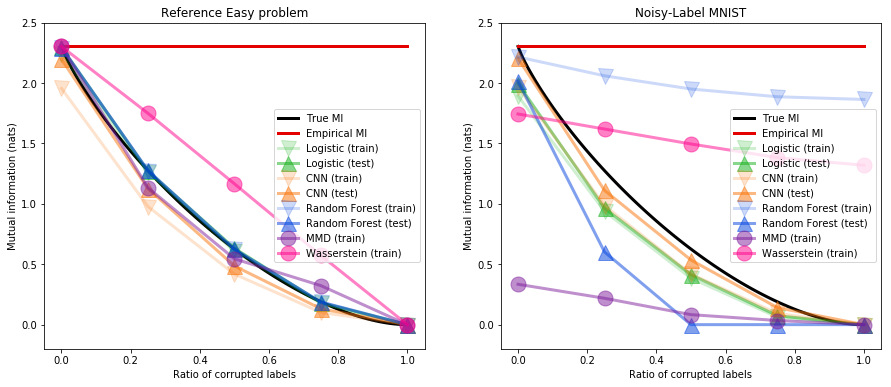

In [29]:
def plot_data(data, label, color, marker=None, **kwargs):
    train_mi = np.log(10) - np.asarray(data['train'])
    test_mi = np.log(10) - np.asarray(data['test'])
    plt.plot(data['corruptions'], np.maximum(train_mi, 0),
             label='{} (train)'.format(label), color=color, 
             alpha=0.2, linewidth=3, markersize=15, marker='v', **kwargs)
    plt.plot(data['corruptions'], np.maximum(test_mi, 0), 
             label='{} (test)'.format(label), color=color, 
             alpha=0.5, linewidth=3, markersize=15, marker='^', **kwargs)
    
def plot_data2(data, label, color, scale=1., marker=None, **kwargs):
    plt.plot(data['corruptions'], scale*np.maximum(data['train'], 0),
             label='{} (train)'.format(label), markersize=15, color=color, 
             marker='o', alpha=0.5, linewidth=3, **kwargs)#, ls='dashed')    

plt.figure(figsize=(15, 6))
MMD_max = np.max(torch.load('reference_mmd.pt')['train'])
MMD_scaling = np.log(10) / MMD_max
Wasserstein_max = np.max(torch.load('reference_wasserstein.pt')['train'])
Wasserstein_scaling = np.log(10) / Wasserstein_max
    
plt.subplot(121)
    

# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('reference_logistic.pt'), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('reference_cnn.pt'), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('reference_rf.pt'), 'Random Forest', 'xkcd:blue', marker=11)
plot_data2(torch.load('reference_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('reference_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    
    
plt.title('Reference Easy problem')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()




plt.subplot(122)


# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('mnist_logistic.pt'), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('mnist_cnn.pt'), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('mnist_rf.pt'), 'Random Forest', 'xkcd:blue', marker=11)
plot_data2(torch.load('mnist_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('mnist_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    

plt.title('Noisy-Label MNIST')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()

plt.savefig('pmi.pdf')

# Plot All SVHN

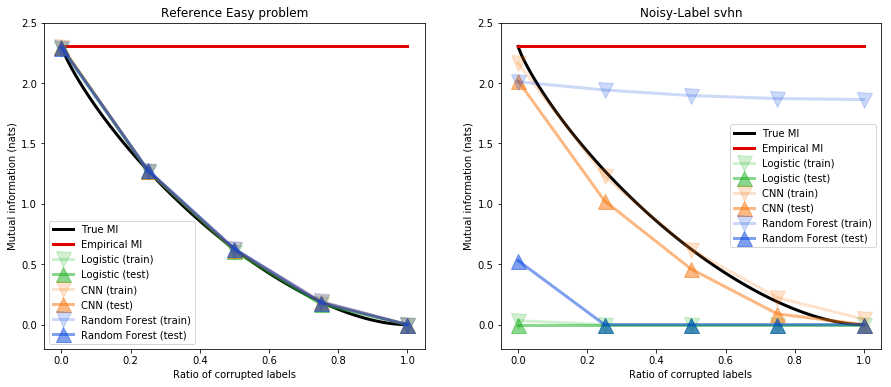

In [147]:
def plot_data(data, label, color, marker=None, **kwargs):
    train_mi = np.log(10) - np.asarray(data['train'])
    test_mi = np.log(10) - np.asarray(data['test'])
    plt.plot(data['corruptions'], np.maximum(train_mi, 0),
             label='{} (train)'.format(label), color=color, 
             alpha=0.2, linewidth=3, markersize=15, marker='v', **kwargs)
    plt.plot(data['corruptions'], np.maximum(test_mi, 0), 
             label='{} (test)'.format(label), color=color, 
             alpha=0.5, linewidth=3, markersize=15, marker='^', **kwargs)
    
def plot_data2(data, label, color, scale=1., marker=None, **kwargs):
    plt.plot(data['corruptions'], scale*np.maximum(data['train'], 0),
             label='{} (train)'.format(label), markersize=15, color=color, 
             marker='o', alpha=0.5, linewidth=3, **kwargs)#, ls='dashed')    

plt.figure(figsize=(15, 6))
#MMD_max = np.max(torch.load('reference_mmd.pt')['train'])
#MMD_scaling = np.log(10) / MMD_max
#Wasserstein_max = np.max(torch.load('reference_wasserstein.pt')['train'])
#Wasserstein_scaling = np.log(10) / Wasserstein_max
    
plt.subplot(121)
    

# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('{}_reference_logistic.pt'.format(args.dataset)), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('{}_reference_cnn.pt'.format(args.dataset)), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('{}_reference_rf.pt'.format(args.dataset)), 'Random Forest', 'xkcd:blue', marker=11)
#plot_data2(torch.load('reference_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
#plot_data2(torch.load('reference_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    
    
plt.title('Reference Easy problem')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()




plt.subplot(122)


# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('{}_real_logistic.pt'.format(args.dataset)), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('{}_real_cnn.pt'.format(args.dataset)), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('{}_real_rf.pt'.format(args.dataset)), 'Random Forest', 'xkcd:blue', marker=11)
#plot_data2(torch.load('mnist_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
#plot_data2(torch.load('mnist_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    

plt.title('Noisy-Label {}'.format(args.dataset))
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()

plt.savefig('pmi.pdf')

In [137]:
torch.load('svhn_real_logistic.pt')

{'corruptions': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'test': [2.306051633976124,
  2.3444733443083585,
  2.3813771406809487,
  2.3702978469707348,
  2.4152873003924333],
 'train': [2.2698342692904077,
  2.3156174822145155,
  2.3446244208573255,
  2.365305486620774,
  2.371861882813633]}

In [13]:
torch.load('reference_mmd.pt')

{'corruptions': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'test': [[0.010616102130270519],
  [0.005225668166203832],
  [0.0025120582583743572],
  [0.001487921724832025],
  [-0.0003301423761611962]],
 'train': [[0.010616102130270519],
  [0.005225668166203832],
  [0.0025120582583743572],
  [0.001487921724832025],
  [-0.0003301423761611962]]}

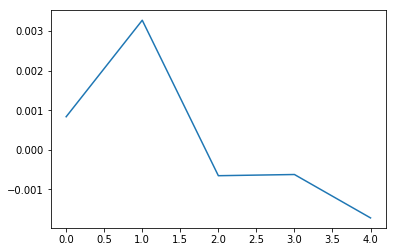

In [14]:
plt.plot(torch.load('mnist_mmd.pt')['train'])